In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings


/Users/haohanwu/venvs/stock/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# download the data
AAPL = yf.download(
        "AAPL",                    # Ticker symbol
        start="2018-01-01",       # Start date  
        end="2025-07-20",         # End date (recent)
        progress=False,           # Don't show progress bar
        auto_adjust=True          # Adjust for splits/dividends
    )
MSFT = yf.download(
        "MSFT",                    
        start="2018-01-01",         
        end="2025-07-20",         
        progress=False,           
        auto_adjust=True          
    )
TSLA = yf.download(
        "TSLA",                    
        start="2018-01-01",       
        end="2025-07-20",         
        progress=False,           
        auto_adjust=True          
    )
NVDA = yf.download(
        "NVDA",                    
        start="2018-01-01",       
        end="2025-07-20",         
        progress=False,          
        auto_adjust=True         
    )


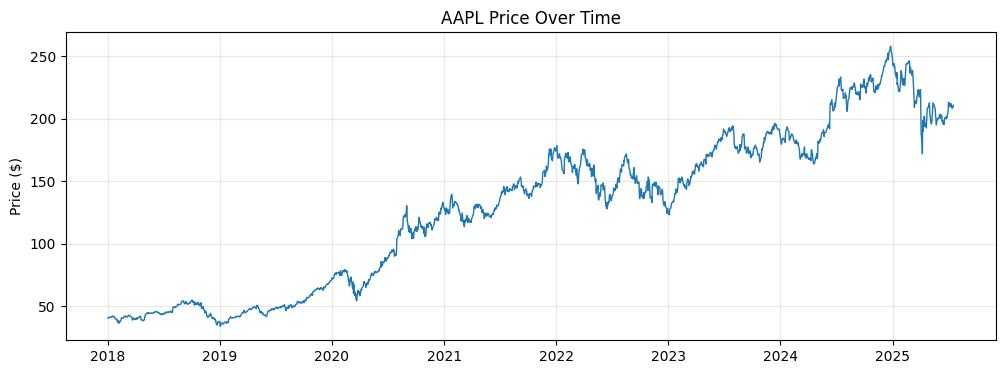

In [3]:
# plot apple as a sample
plt.figure(figsize=(12, 4))
plt.plot(AAPL.index, AAPL['Close'], linewidth=1)
plt.title("AAPL Price Over Time")
plt.ylabel("Price ($)")
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# feature enginnering on the front 80% of data

def feature_engineer(df):
    """Simple feature engineering - calculate features using only past data"""
    df = df.copy()
    
    # Next day's return
    df['Next_Return'] = df['Close'].pct_change().shift(-1)
    
    # 5 day moving average
    df['MA5'] = df['Close'].rolling(window=5, min_periods=1).mean().shift(1)
    
    # z score of 5 day moving average
    ma5 = df['Close'].rolling(window=5, min_periods=1).mean().shift(1)
    std5 = df['Close'].rolling(window=5, min_periods=1).std().shift(1)
    df['Z5'] = (df['Close'] - ma5) / std5
    
    # rsi of 14 days
    df['RSI14'] = compute_rsi(df['Close'], window=14).shift(1)
    
    # volatility of 10 days
    df['Vol10'] = df['Close'].pct_change().rolling(window=10, min_periods=1).std().shift(1)
    
    # lagged returns
    df['Ret1'] = df['Close'].pct_change().shift(1)
    df['Ret5'] = df['Close'].pct_change(5).shift(1)

    # momentum of 10 days
    df['Mom10'] = df['Close'].pct_change(10).shift(1)
    
    # volume change
    df['VolChg'] = df['Volume'].pct_change().shift(1)
    return df.dropna()

# helper for rsi 
def compute_rsi(series, window):

    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# data split 80% for train
total_days_AAPL = len(AAPL)
train_end_AAPL = int(total_days_AAPL * 0.80)
AAPL_train_raw = AAPL.iloc[:train_end_AAPL].copy()
AAPL_val_raw = AAPL.iloc[train_end_AAPL:].copy()

total_days_NVDA = len(NVDA)
train_end_NVDA = int(total_days_NVDA * 0.80)
NVDA_train_raw = NVDA.iloc[:train_end_NVDA].copy()
NVDA_val_raw = NVDA.iloc[train_end_NVDA:].copy()

total_days_TSLA = len(TSLA)
train_end_TSLA = int(total_days_TSLA * 0.80)
TSLA_train_raw = TSLA.iloc[:train_end_TSLA].copy()
TSLA_val_raw = TSLA.iloc[train_end_TSLA:].copy()

total_days_MSFT = len(MSFT)
train_end_MSFT = int(total_days_MSFT * 0.80)
MSFT_train_raw = MSFT.iloc[:train_end_MSFT].copy()
MSFT_val_raw = MSFT.iloc[train_end_MSFT:].copy()

# enginner features
AAPL_train = feature_engineer(AAPL_train_raw)
AAPL_val = feature_engineer(AAPL_val_raw)

NVDA_train = feature_engineer(NVDA_train_raw)
NVDA_val = feature_engineer(NVDA_val_raw)

TSLA_train = feature_engineer(TSLA_train_raw)
TSLA_val = feature_engineer(TSLA_val_raw)

MSFT_train = feature_engineer(MSFT_train_raw)
MSFT_val = feature_engineer(MSFT_val_raw)



In [30]:
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

post_train = {}

for stock_name, train_data, val_data in [('AAPL', AAPL_train, AAPL_val), ('NVDA', NVDA_train, NVDA_val), ('TSLA', TSLA_train, TSLA_val), ('MSFT', MSFT_train, MSFT_val)]:
    
    features = ['MA5','Z5','RSI14','Vol10', 'Ret1', 'Ret5','Mom10', 'VolChg']
    target = 'Next_Return'

    def ridge_alpha(alpha):
        ridge=Ridge(alpha=alpha)
        ridge.fit(train_data[features],train_data[target])
        pred = ridge.predict(val_data[features])

        return -mean_squared_error(val_data[target],pred)
    
    optimizer = BayesianOptimization(
        f=ridge_alpha,
        pbounds={'alpha':(0.001, 100.0)},
        verbose=1,
        random_state=42
    )

    optimizer.maximize(init_points=5, n_iter=25)

    best_alpha = optimizer.max['params']['alpha']
    best_mse = -optimizer.max['target']

    final_model = Ridge(alpha=best_alpha)
    final_model.fit(train_data[features],train_data[target])
    
    post_train[stock_name] = {
        'best_alpha':best_alpha,
        'best_mse':best_mse,
        'model':final_model
    }
    

|   iter    |  target   |   alpha   |
-------------------------------------
| 2         | -0.000354 | 95.071479 |
| 6         | -0.000354 | 99.971767 |
| 7         | -0.000354 | 99.992482 |
| 10        | -0.000354 | 99.997214 |
| 14        | -0.000354 | 99.999204 |
|   iter    |  target   |   alpha   |
-------------------------------------
| 2         | -0.001250 | 95.071479 |
| 6         | -0.001250 | 99.971767 |
| 7         | -0.001250 | 99.992482 |
| 10        | -0.001250 | 99.997214 |
| 14        | -0.001250 | 99.999204 |
|   iter    |  target   |   alpha   |
-------------------------------------
| 5         | -0.001852 | 15.602708 |
| 6         | -0.001847 | 0.0021634 |
| 28        | -0.001847 | 0.0015592 |
|   iter    |  target   |   alpha   |
-------------------------------------
| 7         | -0.000224 | 38.917072 |
| 22        | -0.000224 | 38.918051 |
| 25        | -0.000224 | 39.064664 |
| 26        | -0.000224 | 39.056803 |
| 27        | -0.000224 | 38.992315 |


In [31]:
# A/B bayesian optimization

import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


# Verify no data leakage - check that validation dates come after training dates
for stock_name, train_data, val_data in [('AAPL', AAPL_train, AAPL_val), ('NVDA', NVDA_train, NVDA_val), ('TSLA', TSLA_train, TSLA_val), ('MSFT', MSFT_train, MSFT_val)]:
    train_end_date = train_data.index[-1]
    val_start_date = val_data.index[0]


features = ['MA5','Z5','RSI14','Vol10', 'Ret1', 'Ret5','Mom10', 'VolChg']
target = 'Next_Return'

# store results for comparison
comparison_results = []

for stock_name, train_data, val_data in [('AAPL', AAPL_train, AAPL_val), ('NVDA', NVDA_train, NVDA_val), ('TSLA', TSLA_train, TSLA_val), ('MSFT', MSFT_train, MSFT_val)]:
    
    print(f"\n {stock_name} Analysis:")
    print("-" * 30)
    
    # alpha = 1
    ridge_default = Ridge(alpha=1.0)
    ridge_default.fit(train_data[features], train_data[target])
    pred_default = ridge_default.predict(val_data[features])
    mse_default = mean_squared_error(val_data[target], pred_default)
    r2_default = r2_score(val_data[target], pred_default)
    
    # bayesian optimization
    if stock_name in post_train:
        best_alpha = post_train[stock_name]['best_alpha']
        best_mse = post_train[stock_name]['best_mse']
        
        ridge_optimized = Ridge(alpha=best_alpha)
        ridge_optimized.fit(train_data[features], train_data[target])
        pred_optimized = ridge_optimized.predict(val_data[features])
        mse_optimized = mean_squared_error(val_data[target], pred_optimized)
        r2_optimized = r2_score(val_data[target], pred_optimized)
        
        # Calculate improvement
        mse_improvement = ((mse_default - mse_optimized) / mse_default) * 100
        r2_abs_difference = abs(r2_optimized - r2_default)
        
        print(f"  Before (α=1.0):     MSE={mse_default:.6f}, R²={r2_default:.4f}")
        print(f"  After (α={best_alpha:.3f}): MSE={mse_optimized:.6f}, R²={r2_optimized:.4f}")
        print(f"  Improvement:     MSE: {mse_improvement:+.2f}%, R²: {r2_abs_difference:.2f}")
        
        # Store for summary
        comparison_results.append({
            'Stock': stock_name,
            'Default_MSE': mse_default,
            'Optimized_MSE': mse_optimized,
            'Best_Alpha': best_alpha,
            'MSE_Improvement_%': mse_improvement,
            'Default_R2': r2_default,
            'Optimized_R2': r2_optimized,
            'R2_Improvement_%': r2_improvement
        })

# Summary table
if comparison_results:
    print(f"\n SUMMARY TABLE")
    print("="*80)
    df_results = pd.DataFrame(comparison_results)
    print(df_results.to_string(index=False, float_format='%.4f'))
    
    print(f"Average MSE improvement: {df_results['MSE_Improvement_%'].mean():.2f}%")
    print(f"Best performing stock: {df_results.loc[df_results['MSE_Improvement_%'].idxmax(), 'Stock']}")
    print(f"Most regularization needed: {df_results.loc[df_results['Best_Alpha'].idxmax(), 'Stock']} (α={df_results['Best_Alpha'].max():.2f})")
    print(f"Least regularization needed: {df_results.loc[df_results['Best_Alpha'].idxmin(), 'Stock']} (α={df_results['Best_Alpha'].min():.4f})")



 AAPL Analysis:
------------------------------
  Before (α=1.0):     MSE=0.000356, R²=-0.0112
  After (α=99.999): MSE=0.000355, R²=-0.0069
  Improvement:     MSE: +0.43%, R²: 0.00

 NVDA Analysis:
------------------------------
  Before (α=1.0):     MSE=0.001247, R²=-0.0001
  After (α=99.999): MSE=0.001250, R²=-0.0024
  Improvement:     MSE: -0.23%, R²: 0.00

 TSLA Analysis:
------------------------------
  Before (α=1.0):     MSE=0.001850, R²=0.0007
  After (α=0.002): MSE=0.001848, R²=0.0017
  Improvement:     MSE: +0.10%, R²: 0.00

 MSFT Analysis:
------------------------------
  Before (α=1.0):     MSE=0.000225, R²=-0.0179
  After (α=38.992): MSE=0.000224, R²=-0.0165
  Improvement:     MSE: +0.14%, R²: 0.00

 SUMMARY TABLE
Stock  Default_MSE  Optimized_MSE  Best_Alpha  MSE_Improvement_%  Default_R2  Optimized_R2  R2_Improvement_%
 AAPL       0.0004         0.0004     99.9992             0.4255     -0.0112       -0.0069            7.8927
 NVDA       0.0012         0.0013     99.9992

prediction vs actual (validation)


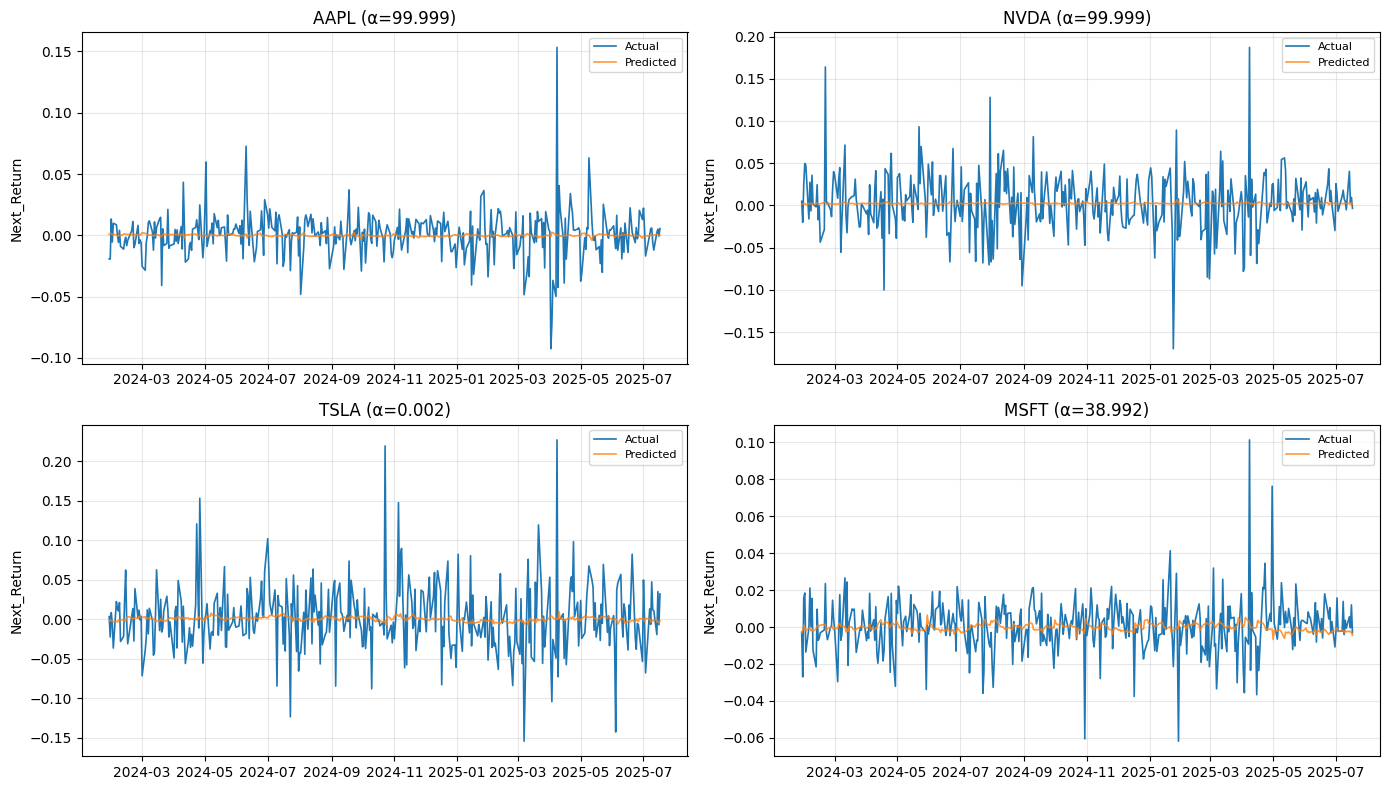

In [32]:
import matplotlib.pyplot as plt

print("prediction vs actual (validation)")
print("=" * 40)

stocks = [('AAPL', AAPL_train, AAPL_val), ('NVDA', NVDA_train, NVDA_val), ('TSLA', TSLA_train, TSLA_val), ('MSFT', MSFT_train, MSFT_val)]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=False)
axes = axes.flatten()

for i, (stock_name, train_data, val_data) in enumerate(stocks):
    if stock_name not in post_train:
        continue

    best_alpha = post_train[stock_name]['best_alpha']
    model = Ridge(alpha=best_alpha)
    model.fit(train_data[features], train_data[target])

    pred = model.predict(val_data[features])
    actual = val_data[target].values

    ax = axes[i]
    ax.plot(val_data.index, actual, label="Actual", linewidth=1.2)
    ax.plot(val_data.index, pred, label="Predicted", linewidth=1.2, alpha=0.8)
    ax.set_title(f"{stock_name} (α={best_alpha:.3f})")
    ax.set_ylabel("Next_Return")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [33]:
#saving models
from joblib import dump, load
import os

# Create directory for saved models
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Save all post_train (models + metadata)
dump(post_train, f'{model_dir}/all_models.joblib')

# Also save individual models for easy access
for stock_name, model_info in post_train.items():
    # Save complete model info
    dump(model_info, f'{model_dir}/{stock_name}_complete.joblib')
    
    # Save just the model for quick loading
    dump(model_info['model'], f'{model_dir}/{stock_name}_model.joblib')

print("Models saved successfully!")

Models saved successfully!
